<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/SoilCarbonModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy
sns.set()

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

In [0]:

data=pd.read_csv('CO2-2.csv')
data=data.values


In [0]:
totalC_t0=7.7 #not included in data
t0=0
Nt=25
ts=data[0:25,1]
eco2mean=data[0:25,2]
eco2sd=data[0:25,3]


ts=ts.astype(float)
eco2mean=eco2mean.astype(float)
eco2sd=eco2sd.astype(float)



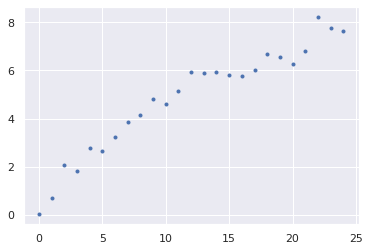

In [4]:
plt.plot(eco2mean,'.')

In [0]:

# Hamiltonian Monte Carlo through Stan

T=100000
bi=int(0.15*T)


stan_data ={"totalC_t0": totalC_t0,
            "t0": t0,
            "N_t": Nt,
            "ts": ts,
            "eCO2mean": eco2mean,
            }



In [6]:
model=pystan.StanModel( file='SoilCarbonmodel.stan' )


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e44bee18dc3aa14fad870d53d114cd79 NOW.


In [7]:

fit = model.sampling(data=stan_data, test_grad = False,
                 iter=T, warmup=bi, chains=2, n_jobs=2)



In [27]:
print(fit)


Inference for Stan model: anon_model_e44bee18dc3aa14fad870d53d114cd79.
2 chains, each with iter=100000; warmup=15000; thin=1; 
post-warmup draws per chain=85000, total post-warmup draws=170000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
k1             0.39    0.13   0.33   0.08   0.13   0.26   0.64   1.01      7   1.13
k2              0.6    0.04   0.39   0.09   0.28   0.57   0.84   1.55    101   1.01
alpha21        1.01    0.02   0.33   0.15    0.9   1.04   1.15   1.66    314    1.0
alpha12        0.54    0.05   0.36   0.03    0.3   0.52   0.71   1.59     46   1.03
gamma          0.91  6.0e-3   0.07   0.72   0.87   0.92   0.96    1.0    144   1.01
sigma          0.35  3.6e-3   0.05   0.27   0.32   0.34   0.37   0.47    202   1.01
eCO2_hat[1]    0.23    0.01   0.17  -0.16   0.12   0.25   0.35   0.53    176   1.01
eCO2_hat[2]    0.57    0.01   0.18   0.17   0.45   0.58   0.69   0.93    265    1.0
eCO2_hat[3]    1.81    0.01   0.16    1.5   1.71 

In [98]:
model_dict=fit.extract()
model_dict.keys()


odict_keys(['k1', 'k2', 'alpha21', 'alpha12', 'gamma', 'sigma', 'eCO2_hat', 'lp__'])

In [29]:
fit_df = fit.to_dataframe()
fit_df.keys()



Index(['chain', 'draw', 'warmup', 'k1', 'k2', 'alpha21', 'alpha12', 'gamma',
       'sigma', 'eCO2_hat[1]', 'eCO2_hat[2]', 'eCO2_hat[3]', 'eCO2_hat[4]',
       'eCO2_hat[5]', 'eCO2_hat[6]', 'eCO2_hat[7]', 'eCO2_hat[8]',
       'eCO2_hat[9]', 'eCO2_hat[10]', 'eCO2_hat[11]', 'eCO2_hat[12]',
       'eCO2_hat[13]', 'eCO2_hat[14]', 'eCO2_hat[15]', 'eCO2_hat[16]',
       'eCO2_hat[17]', 'eCO2_hat[18]', 'eCO2_hat[19]', 'eCO2_hat[20]',
       'eCO2_hat[21]', 'eCO2_hat[22]', 'eCO2_hat[23]', 'eCO2_hat[24]',
       'eCO2_hat[25]', 'lp__', 'accept_stat__', 'stepsize__', 'treedepth__',
       'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object')

In [0]:
fit_df.to_pickle("sample_data/dummy")

In [0]:
fit_df.to_pickle("dummy2")

In [0]:

def pplot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean( param )
    median = np.median( param )
    cred_min, cred_max = np.percentile( param, 2.5 ), np.percentile( param, 97.5 )

    # Plotting
    plt.subplot( 2, 1, 1 )
    plt.plot( param )
    plt.xlabel( 'samples' )
    plt.ylabel( param_name )
    plt.axhline( mean, color='r', lw=2, linestyle='--' )
    plt.axhline( median, color='c', lw=2, linestyle='--' )
    plt.axhline( cred_min, linestyle=':', color='k', alpha=0.2 )
    plt.axhline( cred_max, linestyle=':', color='k', alpha=0.2 )
    plt.title( 'Trace and Posterior Distribution for {}'.format( param_name ) )

    plt.subplot( 2, 1, 2 )
    plt.hist( param, 30, density=True );
    sns.kdeplot( param, shade=True )
    plt.xlabel( param_name )
    plt.ylabel( 'density' )
    plt.axvline( mean, color='r', lw=2, linestyle='--', label='mean' )
    plt.axvline( median, color='c', lw=2, linestyle='--', label='median' )
    plt.axvline( cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI' )
    plt.axvline( cred_max, linestyle=':', color='k', alpha=0.2 )

    plt.gcf().tight_layout()
    plt.legend()


In [0]:

az_data=az.from_pystan(fit )


/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:239: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd741ed0748>,
      dtype=object)

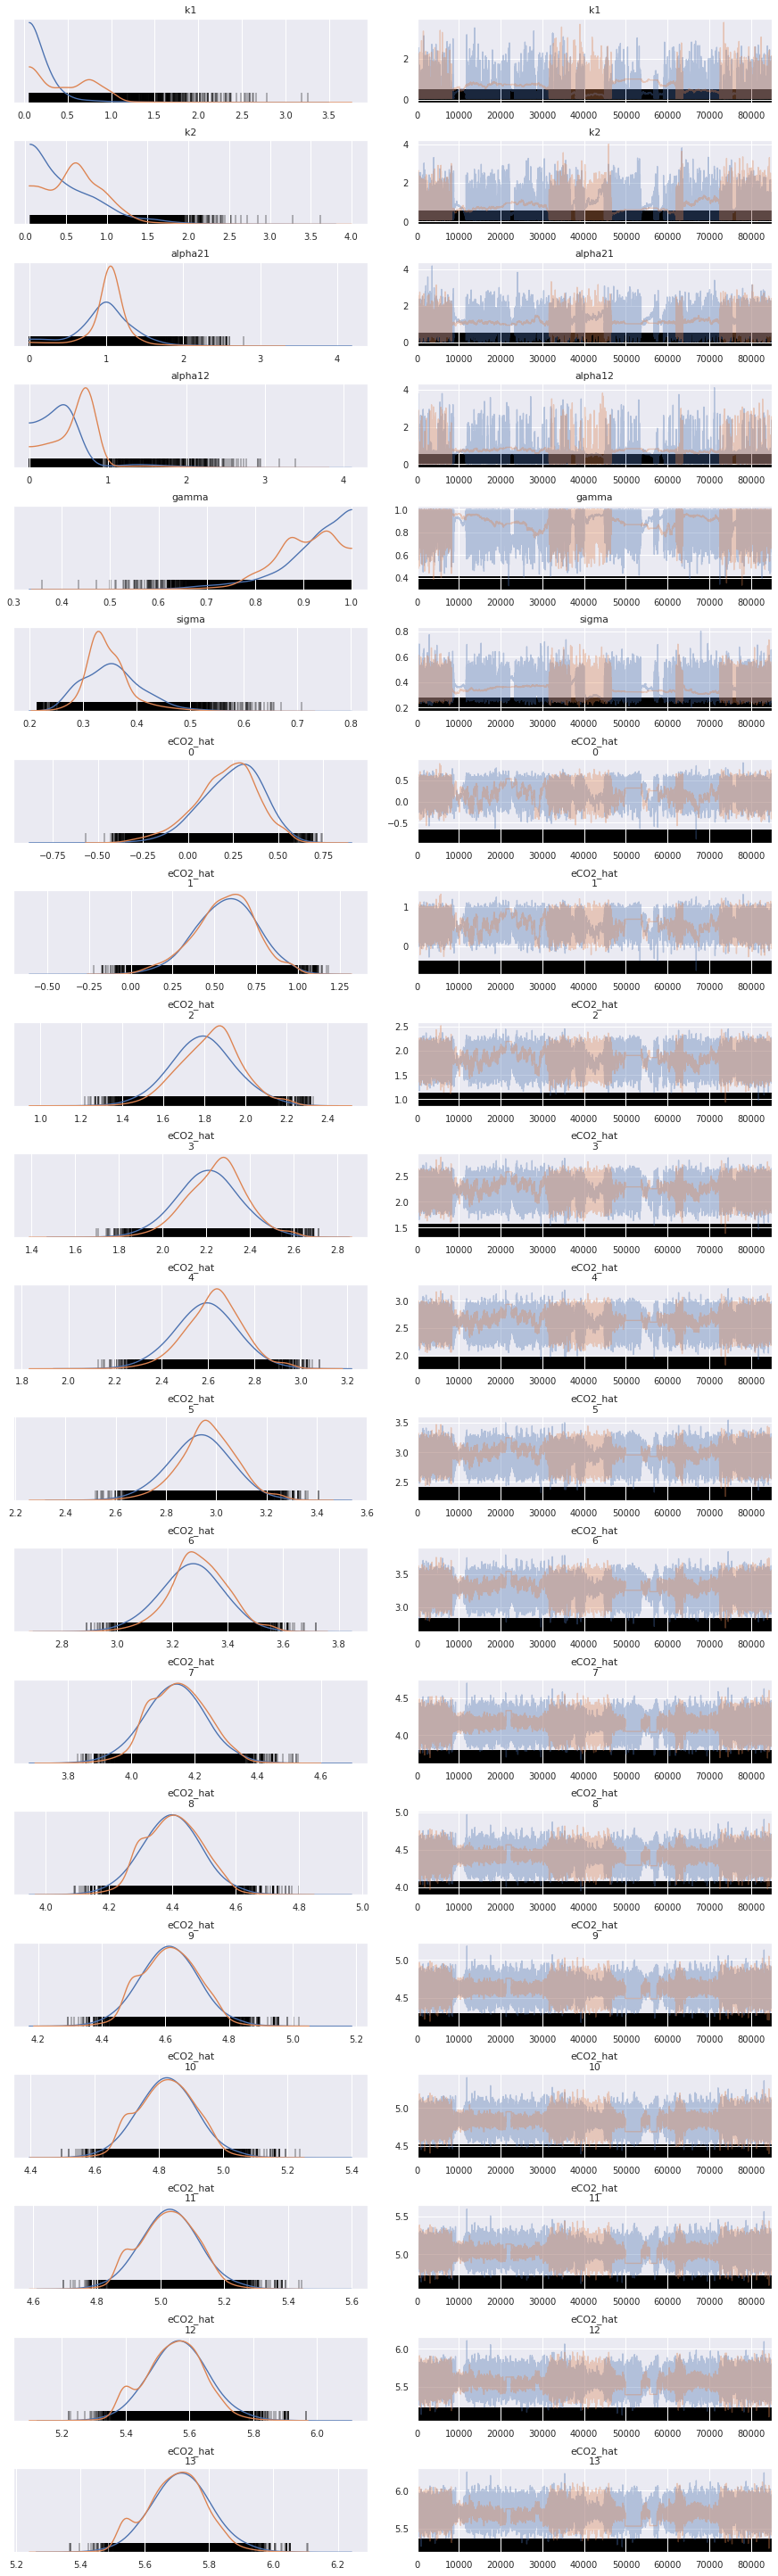

In [34]:
az.plot_trace(az_data)
#each color represents a different chain


In [0]:
draw = fit_df['draw']
k1 = fit_df['k1']
k2 = fit_df['k2']
alpha21=fit_df['alpha21']
alpha12=fit_df['alpha12']
gamma=fit_df['gamma']
sigma=fit_df['sigma']

k1=pd.Series.to_numpy(k1)
k2=pd.Series.to_numpy(k2)
alpha12=pd.Series.to_numpy(alpha12)
alpha21=pd.Series.to_numpy(alpha21)
gamma=pd.Series.to_numpy(gamma)
sigma=pd.Series.to_numpy(sigma)





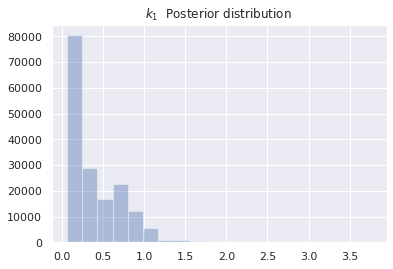

In [62]:
sns.distplot(k1, kde=False, bins=20)
plt.title(r'$ k_1$'+'  Posterior distribution ')
plt.savefig('k1-1.pdf', dpi=500)


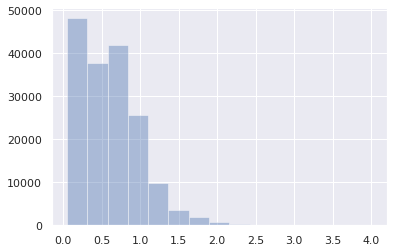

In [39]:
sns.distplot(k2, kde=False,bins=15)


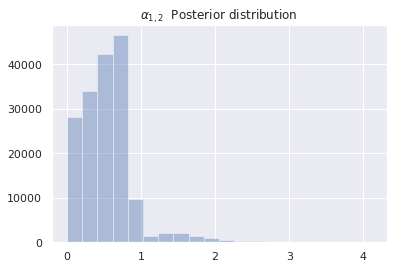

In [63]:
sns.distplot(alpha12, kde=False, bins=20)
plt.title(r'$ \alpha_{1,2}$'+'  Posterior distribution ')
plt.savefig('alpha12-1.pdf', dpi=500)




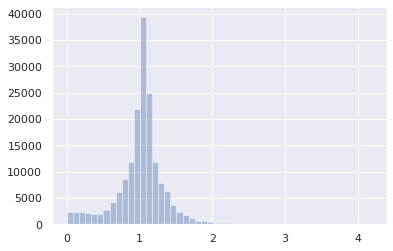

In [41]:
sns.distplot(alpha21,kde=False)


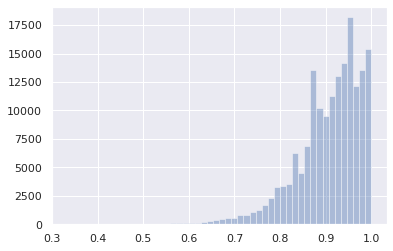

In [42]:
sns.distplot(gamma, kde=False)


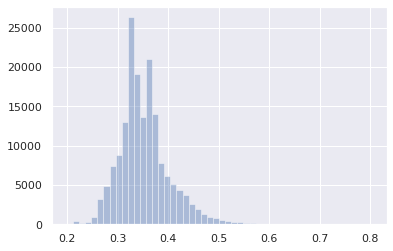

In [43]:
sns.distplot(sigma, kde=False)

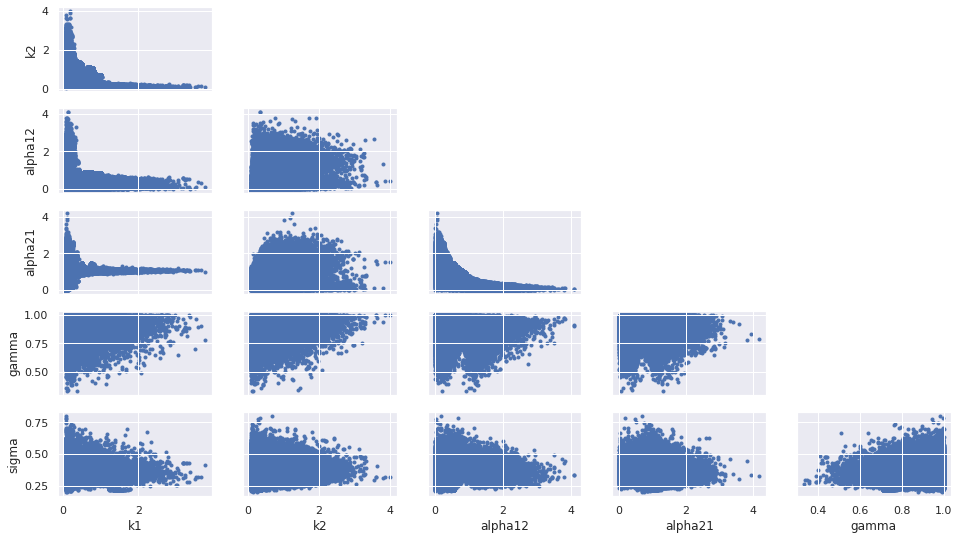

In [94]:
az.plot_pair(az_data,figsize=(16,9) , divergences=False, var_names=['k1', 'k2', 'alpha12', 'alpha21', 'gamma', 'sigma' ] );
plt.savefig('allpairs.png', dpi=500)

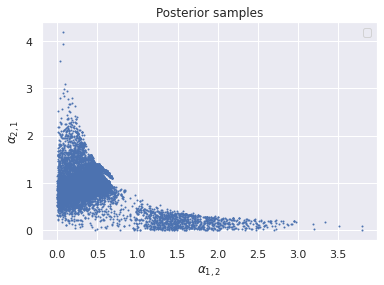

In [79]:
plt.plot(alpha12[0:10000], alpha21[0:10000],'.', markersize=2 )
plt.xlabel( r'$\alpha_{1,2}$' )
plt.ylabel( r'$\alpha_{2,1}$' )
plt.title( 'Posterior samples' )
plt.legend()
plt.savefig( 'PSa1a2-1.png', dpi=500  )
plt.show()

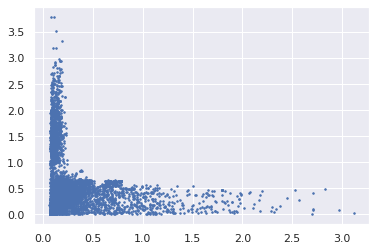

In [82]:
plt.plot(k1[0:10000], alpha12[0:10000],'.', markersize=3)

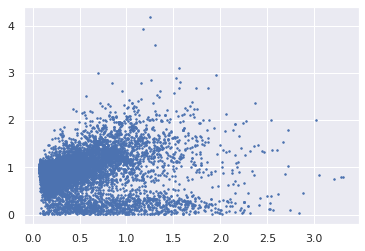

In [83]:
plt.plot(k2[0:10000], alpha21[0:10000],'.', markersize=3)

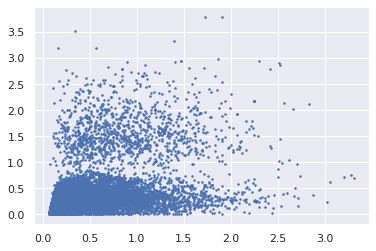

In [76]:
plt.plot(k2[0:15000], alpha12[0:15000],'.', markersize=3)

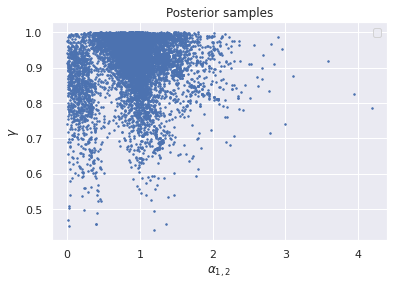

In [80]:
plt.plot(alpha21[0:10000], gamma[0:10000],'.', markersize=3 )
plt.xlabel( r'$\alpha_{1,2}$' )
plt.ylabel( r'$\gamma$' )
plt.title( 'Posterior samples' )
plt.legend()
plt.savefig( 'PSa21gamma-1.png', dpi=500  )
plt.show()

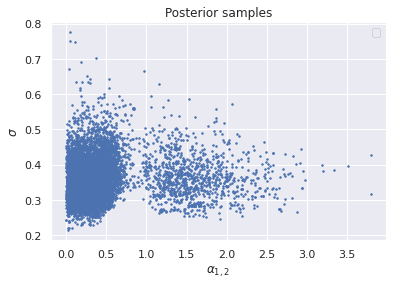

In [81]:

plt.plot(alpha12[0:10000], sigma[0:10000],'.', markersize=3 )
plt.xlabel( r'$\alpha_{1,2}$' )
plt.ylabel( r'$\sigma$' )
plt.title( 'Posterior samples' )
plt.legend()
plt.savefig( 'PSa12sigma-1.png', dpi=500  )
plt.show()

In [0]:
q1=pd.DataFrame.quantile(fit_df, q=0.025)
q2=pd.DataFrame.quantile(fit_df, q=0.975)
medians=pd.DataFrame.median(fit_df)
q1=q1[9:34]
q2=q2[9:34]
medians=medians[9:34]

q1=pd.DataFrame.to_numpy(q1)
q2=pd.DataFrame.to_numpy(q2)
medians=pd.DataFrame.to_numpy(medians)

q1=np.append(0,q1)
q2=np.append(0,q2)
medians=np.append(0, medians)

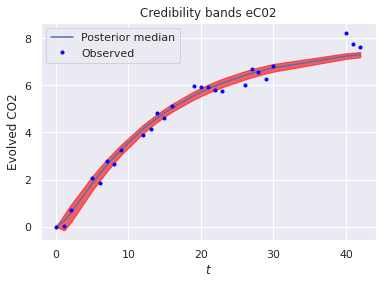

In [46]:

times=np.append(0,ts)

plt.plot(times, medians  , label='Posterior median' )
plt.plot(times,np.append(0,eco2mean), '.',color='blue', label='Observed')
plt.fill_between( times, q1, q2 , alpha=0.6, color='red')
plt.xlabel( r'$t$' )
plt.ylabel( r'Evolved CO2' )
plt.title( 'Credibility bands eC02' )
plt.legend()
plt.savefig( 'eCO2-Bands.png', dpi=500  )
plt.show()



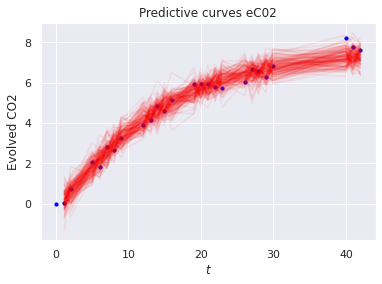

In [86]:
#Predictive Distribution

#Use columns 9 to 34


eC02hats=fit_df.iloc[:, 9:34]

eC02hats=pd.DataFrame.to_numpy(eC02hats)

indexes=np.random.choice(a = np.arange( 0,  eC02hats.shape[0] ), size =150, replace = False)
obs_samples=eC02hats[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(  ts, scipy.stats.norm.rvs( obs_samples[i] , sigma[i] )   , color='red' , alpha=0.07 )
    #plt.plot(  times, np.append(0,obs_samples[i])  , color='red' , alpha=0.07 )

plt.scatter(times, np.append(0,eco2mean) , s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'Evolved CO2' )
plt.title( 'Predictive curves eC02' )
plt.savefig( 'eCO2-predictive-2.png', dpi=500  )
plt.show()


In [50]:
params=fit_df.iloc[:,3:9]
params=pd.DataFrame.to_numpy(params)
params_analysis=Analysis(params)
print('Means: ',params_analysis[ 'Mean'])
print('Medians: ',params_analysis['Median'])
print('Effective sample sizes: ',params_analysis['ess'])

Means:  [0.3923353  0.60218859 1.00925227 0.54115201 0.90593931 0.35259307]
Medians:  [0.26310931 0.56962636 1.03660544 0.51810395 0.92125782 0.34495183]
Effective sample sizes:  [ 14.02890631 107.40207031 306.27535777  89.19169816 148.41850774
 208.13639845]
